In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns


import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from scipy import stats



data = pd.read_csv('heart.csv')

In [2]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
data.shape

(303, 14)

In [5]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# Distribuicao target

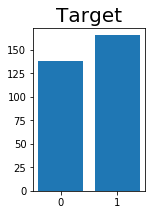

In [7]:
labels = data.target.value_counts().index
sizes = data.target.value_counts().values

plt.figure(figsize=(2,3))
plt.bar(labels, sizes)
plt.xticks(labels)
plt.title('Target', color='black', fontsize=20)
plt.show()

In [8]:
X = data.drop(columns = 'target')
y= data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Normalização

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Correlações

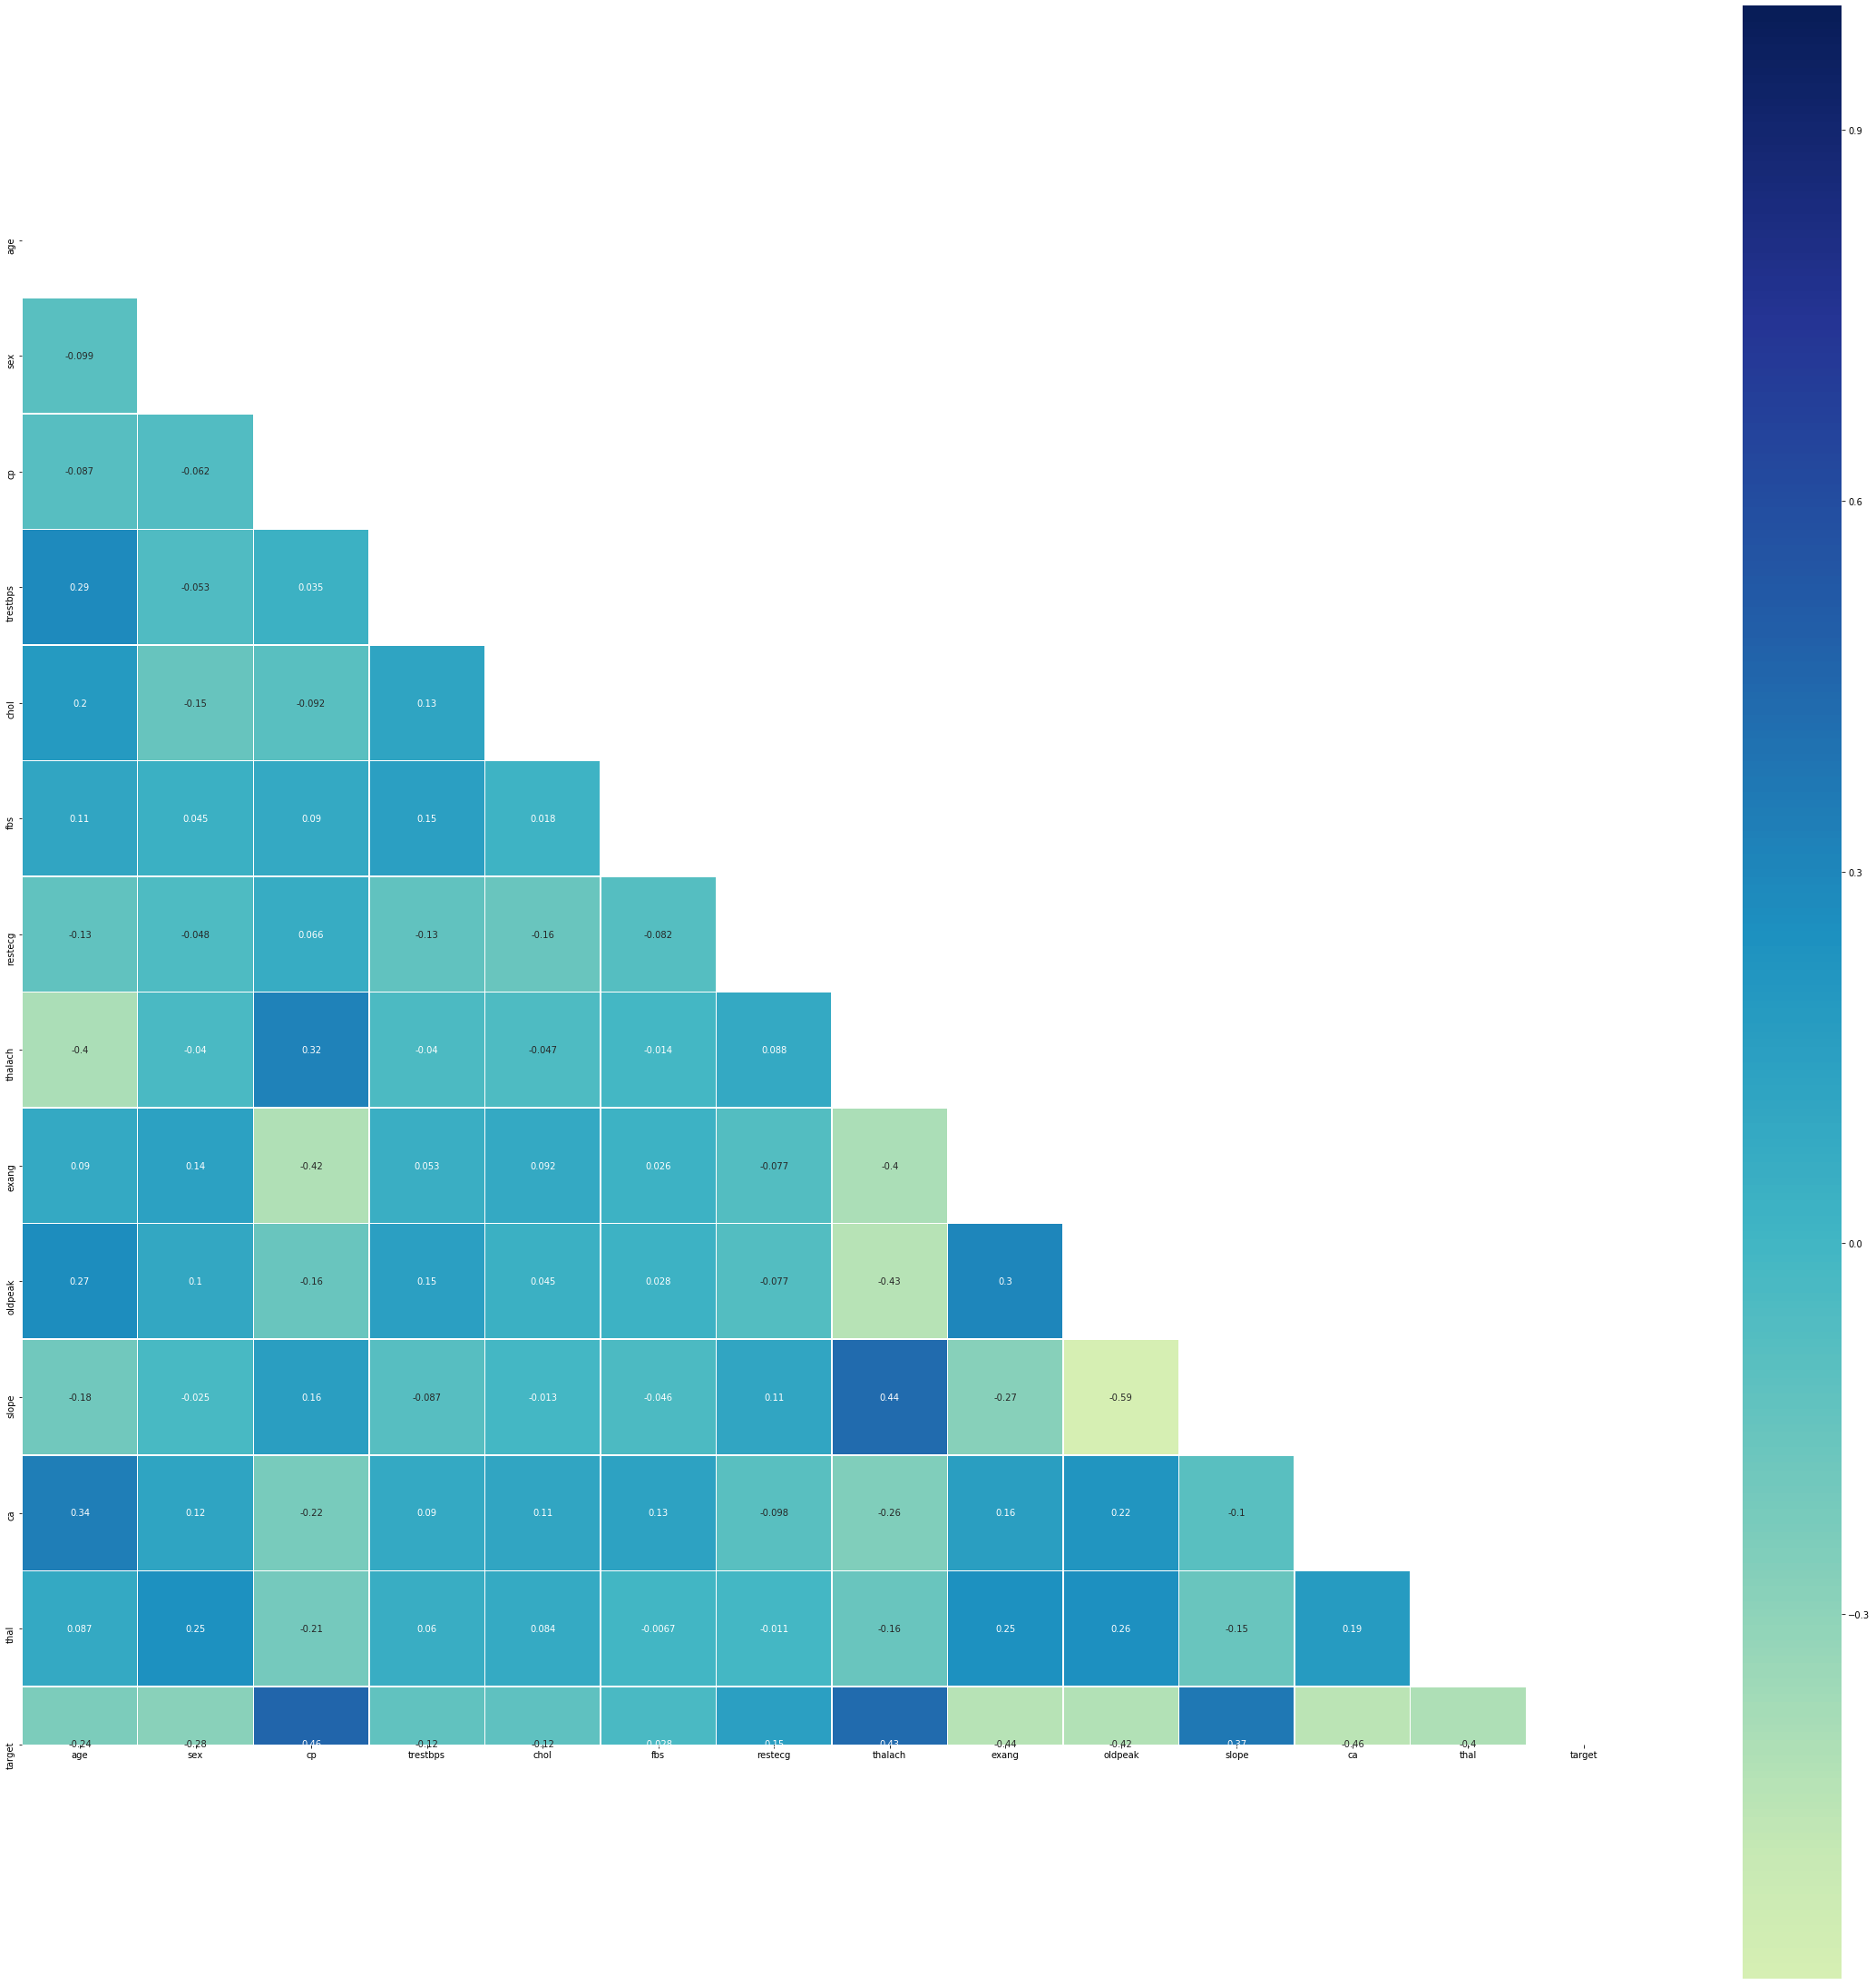

In [10]:
corr = data.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 40))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True,mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

# Distribuição de idades

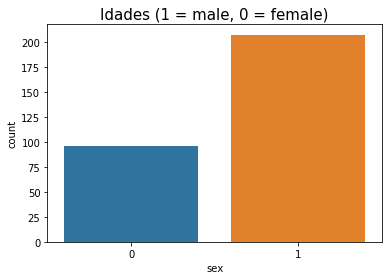

In [11]:
sex = data.sex
sns.countplot(sex)
plt.title('Idades (1 = male, 0 = female)', fontsize=15)
plt.show()

As "melhores" variáveis serão "cp", "thalach", e "slope" ; 
As "piores" variáveis serão "trestbps", "chol" e "fbs"

# Modelação

## Função de model e auc_score

In [12]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

## Random Forest

ROC_AUC = 0.8982683982683983
              precision    recall  f1-score   support

           0    0.92308   0.85714   0.88889        28
           1    0.88571   0.93939   0.91176        33

    accuracy                        0.90164        61
   macro avg    0.90440   0.89827   0.90033        61
weighted avg    0.90286   0.90164   0.90126        61



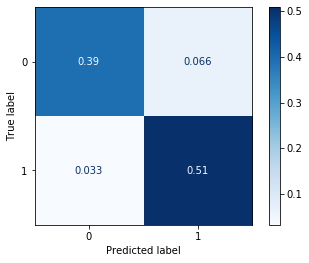

In [26]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 60,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

## LightGBM

ROC_AUC = 0.8982683982683983
              precision    recall  f1-score   support

           0    0.92308   0.85714   0.88889        28
           1    0.88571   0.93939   0.91176        33

    accuracy                        0.90164        61
   macro avg    0.90440   0.89827   0.90033        61
weighted avg    0.90286   0.90164   0.90126        61



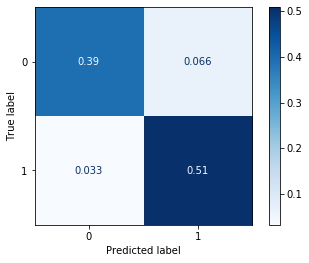

In [14]:
params_lgb ={'colsample_bytree': 0.85, 
         'max_depth': 15, 
         'min_split_gain': 0.1, 
         'n_estimators': 100, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, roc_auc_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

## Catboost

ROC_AUC = 0.9134199134199135
              precision    recall  f1-score   support

           0    0.96000   0.85714   0.90566        28
           1    0.88889   0.96970   0.92754        33

    accuracy                        0.91803        61
   macro avg    0.92444   0.91342   0.91660        61
weighted avg    0.92153   0.91803   0.91749        61



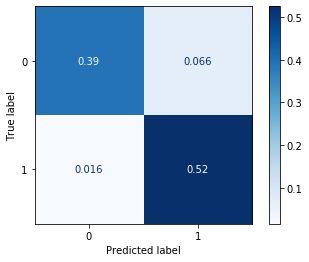

In [15]:
params_cb ={}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, roc_auc_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

## XGBoost

ROC_AUC = 0.8955627705627704
              precision    recall  f1-score   support

           0    0.95833   0.82143   0.88462        28
           1    0.86486   0.96970   0.91429        33

    accuracy                        0.90164        61
   macro avg    0.91160   0.89556   0.89945        61
weighted avg    0.90777   0.90164   0.90067        61



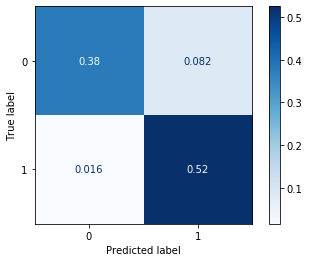

In [16]:
params_xgb ={}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

## Logistic Regression

ROC_AUC = 0.9134199134199135
              precision    recall  f1-score   support

           0    0.96000   0.85714   0.90566        28
           1    0.88889   0.96970   0.92754        33

    accuracy                        0.91803        61
   macro avg    0.92444   0.91342   0.91660        61
weighted avg    0.92153   0.91803   0.91749        61



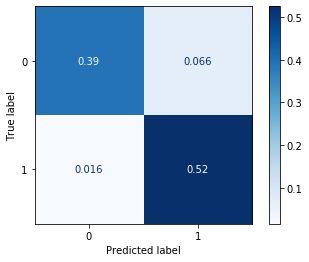

In [17]:
params_log ={}

model_log= LogisticRegression(**params_log)
model_log, roc_auc_log = run_model(model_log, X_train, y_train, X_test, y_test)

## Analisar os scores

In [18]:
auc_scores = [roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb, roc_auc_log]
model_scores = pd.DataFrame(auc_scores, index=['Random Forest','LightGBM','Catboost','XGBoost', 'Logistic Regression'], columns=['AUC_score'])
model_scores.sort_values(by='AUC_score', ascending=False)

,AUC_score
Catboost,0.913420
Logistic Regression,0.913420
Random Forest,0.898268
LightGBM,0.898268
XGBoost,0.895563


# Feature Importance

In [19]:
import eli5
from eli5.sklearn import PermutationImportance

columns_ = data.iloc[:1,:-1].columns
feature_importances = pd.DataFrame(model_cb.feature_importances_,index = columns_,columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

          importance
cp         15.126680
ca         15.114537
thal       11.489335
oldpeak     9.204019
thalach     8.428404
age         7.167764
slope       6.761925
chol        6.595384
restecg     5.325310
sex         5.090324
trestbps    4.912751
exang       3.864307
fbs         0.919258


C:\Users\Alberto\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Alberto\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Otimização Random Forest com Grid

In [28]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

model = RandomForestClassifier()

gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  3.3min finished


In [29]:
print("Best parameters set found on development set:")
print(bestF.best_params_)

Best parameters set found on development set:
{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 300}


## Refazer com parametros otimizados

ROC_AUC = 0.8928571428571428
              precision    recall  f1-score   support

           0    1.00000   0.78571   0.88000        28
           1    0.84615   1.00000   0.91667        33

    accuracy                        0.90164        61
   macro avg    0.92308   0.89286   0.89833        61
weighted avg    0.91677   0.90164   0.89984        61



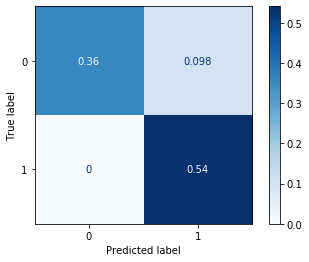

In [32]:
params_rf = {'max_depth': 30,
         'min_samples_leaf': 10,
         'min_samples_split': 5,
         'n_estimators': 300,
         'random_state': 42}

model_rf_opt = RandomForestClassifier(**params_rf)
model_rf_opt, roc_auc_rf_opt = run_model(model_rf_opt, X_train, y_train, X_test, y_test)

In [33]:
auc_scores = [roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb, roc_auc_log,roc_auc_rf_opt]
model_scores = pd.DataFrame(auc_scores, index=['Random Forest','LightGBM','Catboost','XGBoost', 'Logistic Regression', 'Random Forest Opt'], columns=['AUC_score'])
model_scores.sort_values(by='AUC_score', ascending=False)

,AUC_score
Catboost,0.913420
Logistic Regression,0.913420
Random Forest,0.898268
LightGBM,0.898268
XGBoost,0.895563
Random Forest Opt,0.892857


## Com esta otimização mesmo o AUC_score sendo inferior, os casos de "heart_disaese" foram todos detetados, e sendo um dataset de saude é preferencial haver falsos positivos em vez de falsos negativos